In [28]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [29]:
import os
import json
import fitsio
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from astropy.io import ascii
import matplotlib.pyplot as plt

from itertools import combinations_with_replacement

from dr25 import dr25

Start by defining some useful quantities:

In [7]:
session = tf.Session()
durations = np.array([1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0])
cdpp_cols = ["rrmscdpp01p5", "rrmscdpp02p0", "rrmscdpp02p5", "rrmscdpp03p0",
             "rrmscdpp03p5", "rrmscdpp04p5", "rrmscdpp05p0", "rrmscdpp06p0",
             "rrmscdpp07p5", "rrmscdpp09p0", "rrmscdpp10p5", "rrmscdpp12p0",
             "rrmscdpp12p5", "rrmscdpp15p0"]

experiment_name = "sunlike_short_period"

dirname = os.path.join("experiments", experiment_name)
os.makedirs(dirname, exist_ok=True)

clobber = False

fn = os.path.join(dirname, "params.json")
if os.path.exists(fn):
    with open(fn, "r") as f:
        params = json.load(f)
else:
    params = dict(
        max_period=100.0,
        min_teff = 4200,
        max_teff = 6100,
        max_rad = 1.15,
        min_dataspan = 365.25*2.,
        min_dutycycle = 0.6,
        max_cdpp = 1000.0,
    )
    with open(fn, "w") as f:
        json.dump(params, f)

Load the stellar properties table and select a subset.

In [8]:
fn = os.path.join(dirname, "stlr.csv")
if clobber or not os.path.exists(fn):
    berger = pd.read_csv("data/DR2PapTable1.txt", sep="&")
    stlr = ascii.read("data/q1_q17_dr25_stellar.txt").to_pandas()
    stlr = pd.merge(berger, stlr, left_on="KIC", right_on="kepid", suffixes=("", "_stlr"))

    # Only select dwarfs
    m = (params["min_teff"] <= stlr.teff) & (stlr.teff <= params["max_teff"])
    m &= stlr.rad <= params["max_rad"]
    m &= stlr["class\\\\"] == "0\\\\"

    # Only include stars with sufficient data coverage.
    m &= stlr.dataspan > params["min_dataspan"]
    m &= stlr.dutycycle > params["min_dutycycle"]
    m &= stlr.rrmscdpp07p5 <= params["max_cdpp"]

    # Only select stars with logg estimates.
    m &= np.isfinite(stlr.logg)

    stlr = pd.DataFrame(stlr[m])

    # Estimate the best fit quadratic limb darkening model at b=0.5
    c = np.array(stlr[["limbdark_coeff1", "limbdark_coeff2", "limbdark_coeff3", "limbdark_coeff4"]], dtype=float)
    mu = np.sqrt(1.0 - 0.5**2)
    u = np.array([1.0 - mu, (1.0 - mu)**2])
    w = np.array([1.0 - np.sqrt(mu), 1.0 - mu, 1.0 - mu**1.5, 1.0 - mu**2]).T
    norm = np.sum(u**2)
    f = np.sum(c * w, axis=1)
    m = norm > 0
    f[m] /= norm[m]
    gamma = f[:, None] * u.T
    gamma[~m] = 0.5
    stlr["gamma1"] = gamma[:, 0]
    stlr["gamma2"] = gamma[:, 1]

    stlr.to_csv(fn, index=False)
else:
    print("loading saved stellar catalog...")
    stlr = pd.read_csv(fn)
print("selected {0} stars".format(len(stlr)))

selected 54837 stars


Load the flux level transit injections for each star

In [9]:
def get_flti_filename(kicid):
    kid_str = "{0:09d}".format(kicid)
    path = os.path.join("data", "FLTI-DR25-KSOC-5006")
    return os.path.join(path, "kplr{0}_dr25_5006_flti.fits".format(kid_str))

filename = os.path.join(dirname, "flti.h5")

if clobber or not os.path.exists(filename):
    hdr_keys = [
        "KEPLERID", "RADIUS", "TEFF", "LOGG", "FEH",
        "LIMBD1", "LIMBD2", "LIMBD3", "LIMBD4",
    ]
    datasets = []
    ntargets = 0
    for _, star in tqdm(stlr.iterrows(), total=len(stlr)):
        fn = get_flti_filename(int(star.kepid))
        if not os.path.exists(fn):
            continue
        ntargets += 1
        data = fitsio.read(fn)
        m = data["Period"] < params["max_period"]
        data = data[m]
        df = pd.DataFrame.from_records(data.byteswap().newbyteorder())
        hdr = fitsio.read_header(fn, 0)
        for c in hdr_keys:
            df[c.lower()] = hdr[c]
        datasets.append(df)
    flti = pd.concat(datasets)
    del datasets

    cols = cdpp_cols + ["kepid", "rad", "teff", "logg", "dataspan", "dutycycle",
                        "cdppslplong", "cdppslpshrt", "gamma1", "gamma2"]
    flti = pd.merge(flti, stlr[cols], left_on="keplerid", right_on="kepid", suffixes=("flti", ""))
    flti.to_hdf(filename, "flti", index=False)
    
    print("loaded {0} injections for {1} targets".format(len(flti), ntargets))
    
    flti_params = dict(
        n_stlr=len(stlr),
        n_inj=len(flti),
        n_inj_targ=ntargets,
    )
    with open(os.path.join(dirname, "flti_params.json"), "w") as f:
        json.dump(flti_params, f)
else:
    print("loading saved transit injections...")
    flti = pd.read_hdf(filename, "flti")

100%|██████████| 54837/54837 [01:49<00:00, 500.06it/s]
/Users/dforeman/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block4_values] [items->['keplerid']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


loaded 9950082 injections for 9239 targets


Compare the stellar catalog and the stars with injections

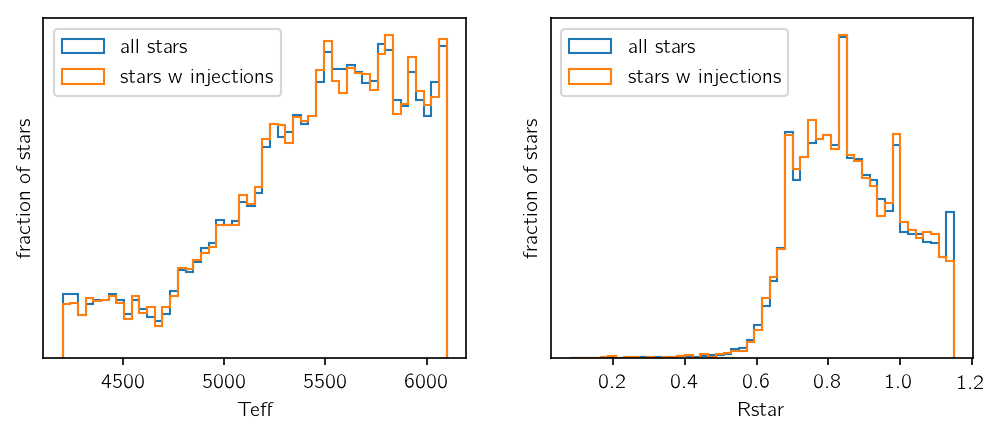

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
n, bins, _ = ax.hist(stlr.teff, 50, histtype="step", label="all stars", density=True)
ax.hist(flti.groupby("kepid").mean().teff, bins, histtype="step", label="stars w injections", density=True)
ax.set_xlabel("Teff")
ax.set_ylabel("fraction of stars")
ax.set_yticks([])
ax.legend(loc=2)

ax = axes[1]
n, bins, _ = ax.hist(stlr.rad, 50, histtype="step", label="all stars", density=True)
ax.hist(flti.groupby("kepid").mean().rad, bins, histtype="step", label="stars w injections", density=True)
ax.set_xlabel("Rstar")
ax.set_ylabel("fraction of stars")
ax.set_yticks([])
ax.legend(loc=2);

Load the pixel level injections and Robovetter classifications

In [12]:
# Load the injections
inj = ascii.read("data/kplr_dr25_inj1_plti.txt").to_pandas()
inj["kepid"] = inj.KIC_ID.astype(int)
m = inj.i_depth > 0.0
m &= inj.i_period < params["max_period"]
m &= inj.EB_injection < 1.0
m &= inj.Offset_from_source < 1.0
inj = inj[m]

# Load the robovetter results
robo = ascii.read("data/kplr_dr25_inj1_tces.txt").to_pandas()

# Only select the injections in our subsample
inj = pd.merge(inj, stlr, on="kepid", suffixes=("", "_stlr"))
inj = pd.merge(inj, robo, how="left", suffixes=("", "_robo"), on="TCE_ID")
m1 = inj.Recovered > 0
m2 = inj.Disp == "PC"
robo_eff = m2.sum() / m1.sum()

print("selected {0} pixel-level injections".format(len(inj)))
print("average robovetter efficiency: {0:.1f}%".format(100*robo_eff))

with open(os.path.join(dirname, "robo.json"), "w") as f:
    json.dump({"num": len(inj), "eff": robo_eff}, f)

selected 8170 pixel-level injections
average robovetter efficiency: 93.8%


Build the completeness model in TF

In [33]:
T = tf.float64

R_star = tf.placeholder(T, (None,), name="R_star")
logg_star = tf.placeholder(T, (None,), name="logg_star")
gamma_star = tf.placeholder(T, (None, 2), name="gamma_star")
cdpp_star = tf.placeholder(T, (None, len(durations)), name="cdpp_star")
dataspan_star = tf.placeholder(T, (None,), name="dataspan_star")
dutycycle_star = tf.placeholder(T, (None,), name="dutycycle_star")
R_pl = tf.placeholder(T, (None,), name="R_pl")
P_pl = tf.placeholder(T, (None,), name="P_pl")
b_pl = tf.placeholder(T, (None,), name="b_pl")

# Completeness model
comp_norm = tf.Variable(0.998, dtype=T, name="comp_norm")
use_sigmoid = True
if use_sigmoid:
    mes0_p = tf.Variable([9.96256681,  0.2756897 , -5.70218461], dtype=T, name="mes0")
    log_sig_mes_p = tf.Variable([-2.03610317, -1.02969026,  1.20723835], dtype=T, name="log_sig_mes")
    comp_pars = [comp_norm, log_sig_mes_p, mes0_p]
else:  
    mes0_p = tf.Variable([5.6091, 2.7272, -6.2656], dtype=T, name="mes0")
    log_alpha_p = tf.Variable([1.51, 0.01], dtype=T, name="log_alpha_p")
    log_beta_p = tf.Variable([-0.0337, 0.5811, 0.0], dtype=T, name="log_beta_p")
    comp_pars = [comp_norm, log_alpha_p, log_beta_p, mes0_p]
    
# comp_pars = tf.Variable([0.95, np.log(4.0), np.log(2.0)], dtype=T, name="comp_pars")
recovered = tf.placeholder(T, (None,), name="recovered")
weight = tf.placeholder(T, (None,), name="weight")

# Estimate the transit properties
ror_pl = R_pl / R_star
M_star = 10.0**(logg_star-4.437) * tf.square(R_star)
a_pl = 215.0 * M_star**(1.0/3.0) * (P_pl/365.25)**(2.0/3.0)
a_pl_sin_i = tf.sqrt(tf.square(a_pl) - tf.square(R_star * b_pl))
arg = (1.0+ror_pl)**2-b_pl**2
arg = tf.clip_by_value(arg, tf.zeros_like(arg), arg)
tau_tot = P_pl * tf.asin(R_star * tf.sqrt(arg) / a_pl_sin_i) / np.pi
arg = (1.0-ror_pl)**2-b_pl**2
arg = tf.clip_by_value(arg, tf.zeros_like(arg), arg)
tau_full = P_pl * tf.asin(R_star * tf.sqrt(arg) / a_pl_sin_i) / np.pi
shape_pl = tau_full / tau_tot
tau_pl = 0.5 * (tau_tot + tau_full)

depth = (1.0 - dr25.quad(gamma_star[:, 0], gamma_star[:, 1], ror_pl, b_pl)) * 1e6

# The completeness model should be a function of duration
x = shape_pl
x2 = tf.square(x)
mes0 = mes0_p[0] + mes0_p[1] * x + mes0_p[2] * x2
if use_sigmoid:
    log_sig_mes = log_sig_mes_p[0] + log_sig_mes_p[1] * x + log_sig_mes_p[2] * x2
else:
    log_alpha = log_alpha_p[0] + log_alpha_p[1] * x
    log_beta = log_beta_p[0] + log_beta_p[1] * x + log_beta_p[2] * x2

# Interpolate the CDPP grid
cdpp = dr25.interp(tau_full, durations, cdpp_star)

# Estimate the MES
ntran = dataspan_star * dutycycle_star / P_pl
mes = tf.sqrt(ntran) * depth / cdpp

# Completeness as a function of MES
if use_sigmoid:
    pdet = comp_norm / (1.0 + tf.exp(-(tf.log(mes) - tf.log(mes0)) * tf.exp(-log_sig_mes)))
else:
    a = tf.exp(log_alpha)
    pdet = tf.where(mes > mes0,
                    comp_norm * tf.igamma(a, tf.exp(log_beta)*tf.abs(mes - mes0)),
                    tf.zeros_like(mes))
pdet = tf.clip_by_value(pdet, 0.0, 1.0)

# Fit completeness parameters to injections
chi2 = tf.norm((pdet - recovered) * weight)
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, comp_pars)

session.run(tf.global_variables_initializer())

ror = 0.009158*np.array(flti.Rp / flti.radius)
feed = {
    R_star: np.array(flti.rad),
    logg_star: np.array(flti.logg),
    gamma_star: np.array(flti[["gamma1", "gamma2"]]),
    cdpp_star: np.array(flti[cdpp_cols]),
    dataspan_star: np.array(flti.dataspan),
    dutycycle_star: np.array(flti.dutycycle),
    R_pl: ror * np.array(flti.rad),
    P_pl: np.array(flti.Period),
    b_pl: np.array(flti.b),
    recovered: np.array((flti.Recovered == 1), dtype=float),
}

mes_val = session.run(mes, feed_dict=feed)
x, y = session.run([mes, shape_pl], feed_dict=feed)
bins = (np.linspace(0.1, 30, 45), np.linspace(y.min(), y.max(), 18))
ntot, _, _ = np.histogram2d(mes_val, y, bins)
ntot = np.concatenate((ntot[:1], ntot, ntot[-1:]), axis=0)
ntot = np.concatenate((ntot[:, :1], ntot, ntot[:, -1:]), axis=1)
ix = np.digitize(x, bins[0])
iy = np.digitize(y, bins[1])
w_vals = ntot[ix, iy]
w_vals /= np.mean(w_vals)
feed[weight] = 1./w_vals 

print("Initial chi2: {0}".format(session.run(chi2, feed_dict=feed)))

Initial chi2: 43226.74943652558


In [34]:
y = session.run(shape_pl, feed_dict=feed)
bins = (
    np.linspace(0.1, 30, 45),
    np.linspace(y.min(), y.max(), 18)
)
b_x = 0.5*(bins[0][1:] + bins[0][:-1])
b_y = 0.5*(bins[1][1:] + bins[1][:-1])

ntot, _, _ = np.histogram2d(mes_val, y, bins)
m = flti.Recovered == 1
nrec, _, _ = np.histogram2d(mes_val[m], y[m], bins)
Z = nrec / ntot

X, Y = np.meshgrid(b_x, b_y, indexing="ij")
Z_mod = session.run(pdet, {mes: X.flatten(), shape_pl: Y.flatten()}).reshape(X.shape)

Text(0.5,0,'shape parameter')

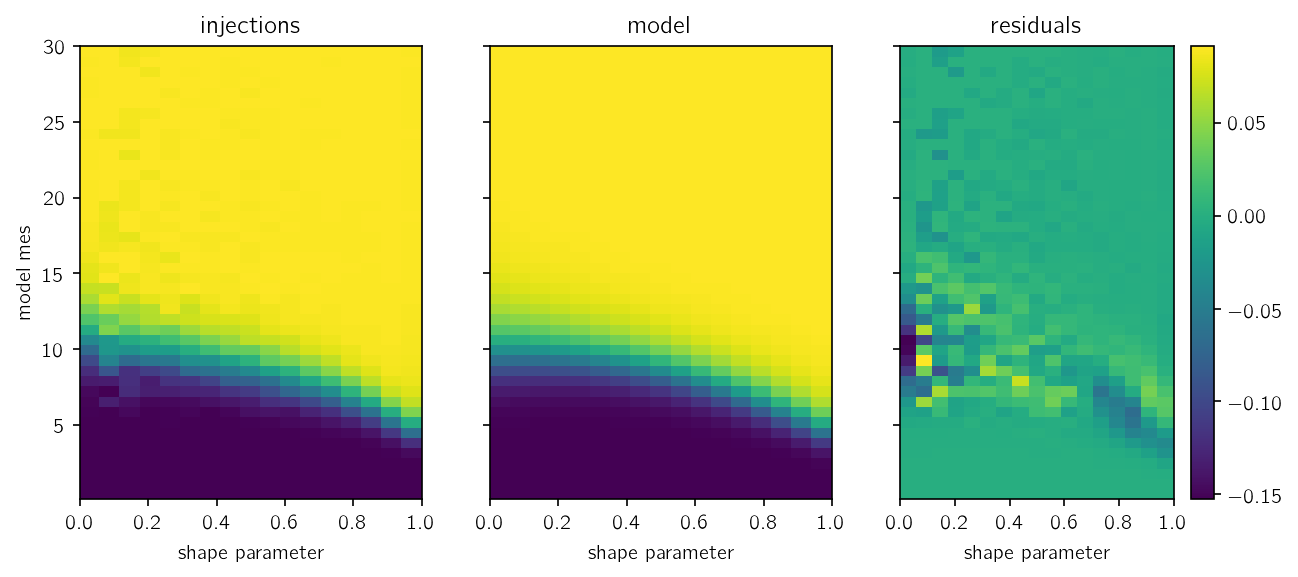

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
ax[0].pcolor(bins[1], bins[0], Z)
ax[0].set_title("injections")
ax[0].set_ylabel("model mes")
ax[0].set_xlabel("shape parameter")

ax[1].pcolor(bins[1], bins[0], Z_mod)
ax[1].set_title("model")
ax[1].set_xlabel("shape parameter")

c = ax[2].pcolor(bins[1], bins[0], Z - Z_mod)
fig.colorbar(c)
ax[2].set_title("residuals")
ax[2].set_xlabel("shape parameter")

In [36]:
opt.minimize(session, feed_dict=feed)
print(session.run(chi2, feed_dict=feed))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 43226.554056
  Number of iterations: 12
  Number of functions evaluations: 22
43226.55405645638


In [37]:
session.run(comp_pars)

[0.9981739050666535,
 array([-2.03880665, -1.00905744,  1.16626201]),
 array([ 9.95135684,  0.34842415, -5.76792672])]

In [47]:
pdet_params = dict(
    comp_norm=session.run(comp_norm),
    mes0=session.run(mes0_p).tolist(),
    log_sigma_mes=session.run(log_sig_mes_p).tolist(),
)
with open(os.path.join(dirname, "pdet_model.json"), "w") as f:
    json.dump(pdet_params, f)

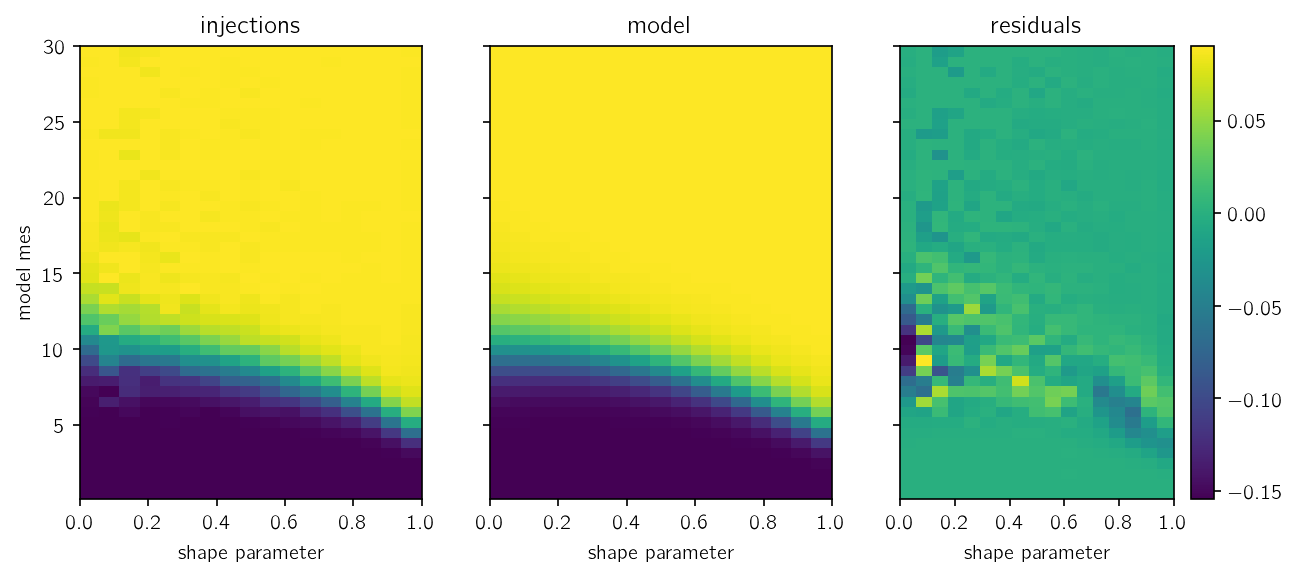

In [44]:
Z_mod = session.run(pdet, {mes: X.flatten(), shape_pl: Y.flatten()}).reshape(X.shape)

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
ax[0].pcolor(bins[1], bins[0], Z)
ax[0].set_title("injections")
ax[0].set_ylabel("model mes")
ax[0].set_xlabel("shape parameter")

ax[1].pcolor(bins[1], bins[0], Z_mod)
ax[1].set_title("model")
ax[1].set_xlabel("shape parameter")

c = ax[2].pcolor(bins[1], bins[0], Z - Z_mod)
fig.colorbar(c)
ax[2].set_title("residuals")
ax[2].set_xlabel("shape parameter")

plt.savefig(os.path.join(dirname, "pdet_contours.pdf"), bbox_inches="tight");

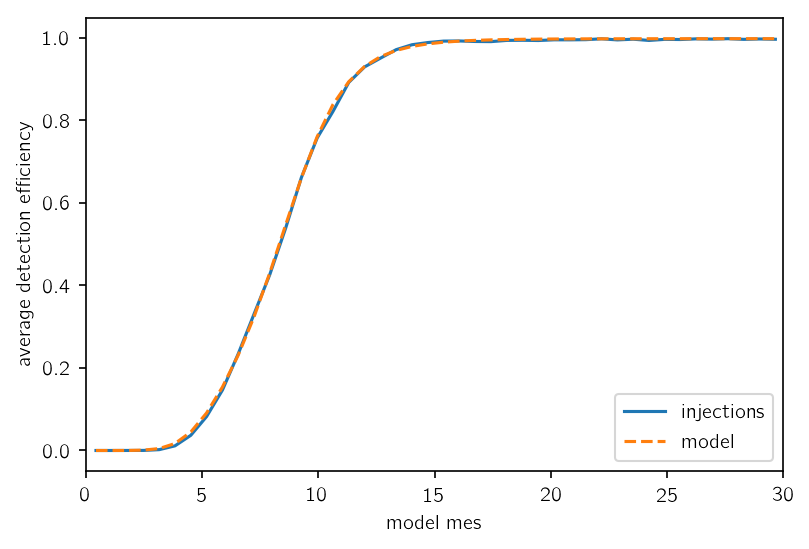

In [45]:
plt.plot(b_x, np.mean(Z, axis=1), label="injections")
plt.plot(b_x, np.mean(Z_mod, axis=1), "--", label="model")
plt.xlabel("model mes")
plt.ylabel("average detection efficiency")
plt.legend(loc=4)
plt.xlim(0, 30)
plt.savefig(os.path.join(dirname, "pdet_mean.pdf"), bbox_inches="tight");

Text(0,0.5,'average efficiency residual')

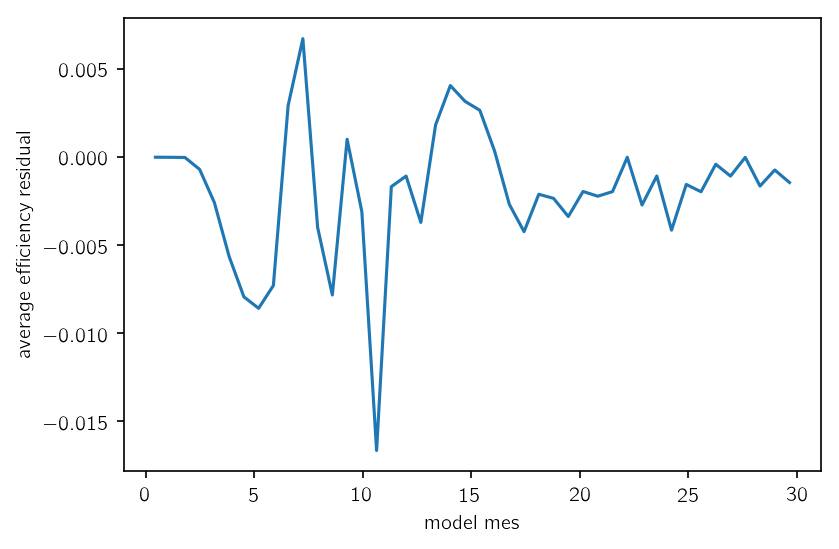

In [42]:
plt.plot(b_x, np.mean(Z, axis=1) - np.mean(Z_mod, axis=1))
plt.xlabel("model mes")
plt.ylabel("average efficiency residual")